In [1]:
# Add timestap
import datetime
print(f'notebook last run (end_to_end):{datetime.datetime.now()}')

notebook last run (end_to_end):2023-07-17 21:26:51.829789


In [2]:
# am i using GPU?
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
 # get data (10% of labels)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip
zip_ref=zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2023-07-17 21:47:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   205MB/s    in 0.8s    

2023-07-17 21:47:28 (205 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# walking through the dir
import os
for dir_path, dir_names, file_names in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dir_names)} directories and {len(file_names)} images in {dir_path}')

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 10 directori

In [9]:
# Creating DataLoaders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print('training image')
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'

)
print('Testing data')
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


training image
Found 750 images belonging to 10 classes.
Testing data
Found 2500 images belonging to 10 classes.


there are testing data number 2500 where training data 750 lol

Setting up callbacks

In [12]:
#create tensorboard callback
import tensorflow as tf

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback=tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f'Saving TensorBoard log files to :{log_dir}')
  return tensorboard_callback

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_url_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [15]:
def create_model(model_url, num_classes=10):
  '''Takes a TensorFlow Hub URL and creates a Keras Sequential Model with it.
  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in output layer,
    should be equal to number of classes, here default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extrator layer and Dense output layer with num_classes outputs.
  '''

  # Download the pretrain model and save it as a keras layer
  feature_extractor_layer=hub.KerasLayer(
      model_url,
      trainable=False,
      name='feature_extraction_layer',
      input_shape=IMAGE_SHAPE+(3,)
  )

  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [17]:
train_data.num_classes

10

In [18]:
# create model for resnet
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [19]:
# fit the model
resnet_history=resnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    # add tensorBoard callbacks
    callbacks=[create_tensorboard_callback(dir_name='tenflow_hub',
                                           experiment_name='resnet50V2'
                                           )]
)

Saving TensorBoard log files to :tenflow_hub/resnet50V2/20230718-013903
Epoch 1/5
24/24 [==============================] - 575s 25s/step - loss: 1.9099 - accuracy: 0.3360 - val_loss: 1.1832 - val_accuracy: 0.6388
Epoch 2/5
24/24 [==============================] - 544s 23s/step - loss: 0.8880 - accuracy: 0.7373 - val_loss: 0.8444 - val_accuracy: 0.7280
Epoch 3/5
24/24 [==============================] - 570s 24s/step - loss: 0.6069 - accuracy: 0.8387 - val_loss: 0.7383 - val_accuracy: 0.7588
Epoch 4/5
24/24 [==============================] - 543s 23s/step - loss: 0.4625 - accuracy: 0.8867 - val_loss: 0.6968 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 568s 24s/step - loss: 0.3742 - accuracy: 0.9147 - val_loss: 0.6834 - val_accuracy: 0.7728


In [21]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


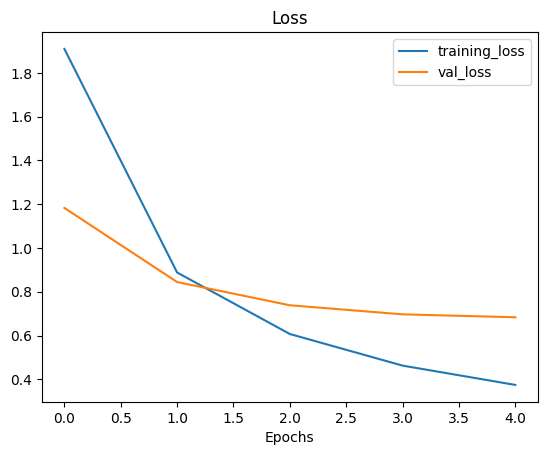

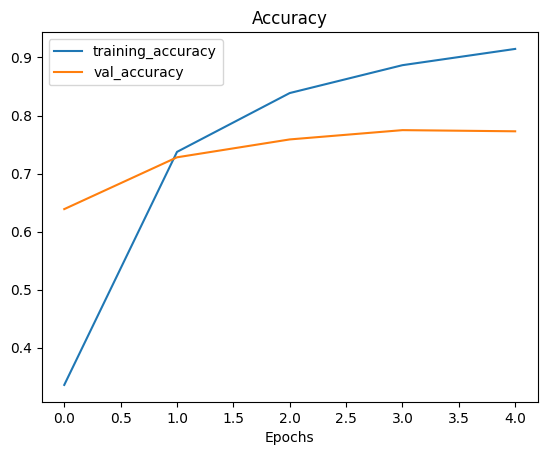

In [22]:
plot_loss_curves(resnet_history)

In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
# efficientnet model
efficientnet_model = create_model(model_url=efficientnet_url, num_classes=train_data.num_classes)

#compile
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [25]:
efficientnet_history = efficientnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    # callbacks
    callbacks=[create_tensorboard_callback(dir_name='tenflow_hub',
                                           experiment_name='efficientnet')]
)

Saving TensorBoard log files to :tenflow_hub/efficientnet/20230718-024135
Epoch 1/5
24/24 [==============================] - 342s 14s/step - loss: 1.8638 - accuracy: 0.4160 - val_loss: 1.3188 - val_accuracy: 0.7036
Epoch 2/5
24/24 [==============================] - 326s 14s/step - loss: 1.0672 - accuracy: 0.7627 - val_loss: 0.8829 - val_accuracy: 0.8100
Epoch 3/5
24/24 [==============================] - 324s 14s/step - loss: 0.7551 - accuracy: 0.8280 - val_loss: 0.7124 - val_accuracy: 0.8360
Epoch 4/5
24/24 [==============================] - 265s 11s/step - loss: 0.6086 - accuracy: 0.8693 - val_loss: 0.6243 - val_accuracy: 0.8476
Epoch 5/5
24/24 [==============================] - 322s 14s/step - loss: 0.5130 - accuracy: 0.8960 - val_loss: 0.5693 - val_accuracy: 0.8588


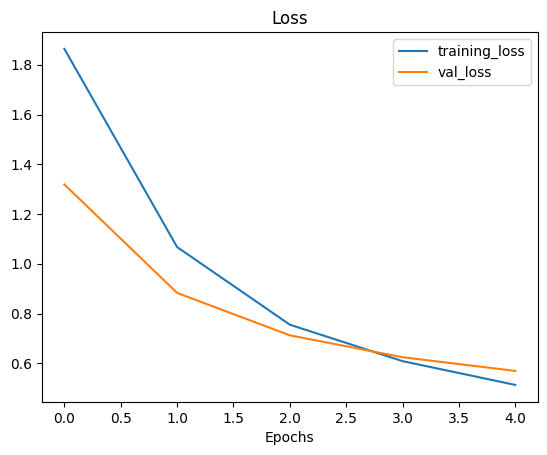

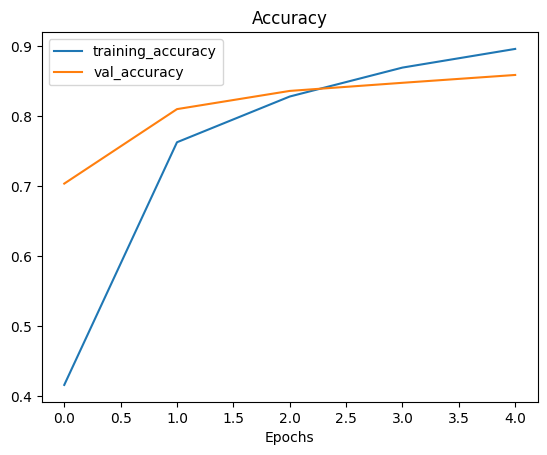

In [26]:
plot_loss_curves(efficientnet_history)

In [27]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


here, resnet is more overfitted then efficentnet.

Uploading experiments to TensorBoard

In [32]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tenflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-07-18 03:47:07.263424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/t4dcqM1SRy6ck4tJOCrRnQ/

[2023-07-18T03:47:09] Started scanning logdir.
[2023-07-18T03:47:11] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.7 MB)
[2023-07-18T03:47:11] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/t4dcqM1SRy6ck4tJOCrRnQ/


it's looks good to see :-) 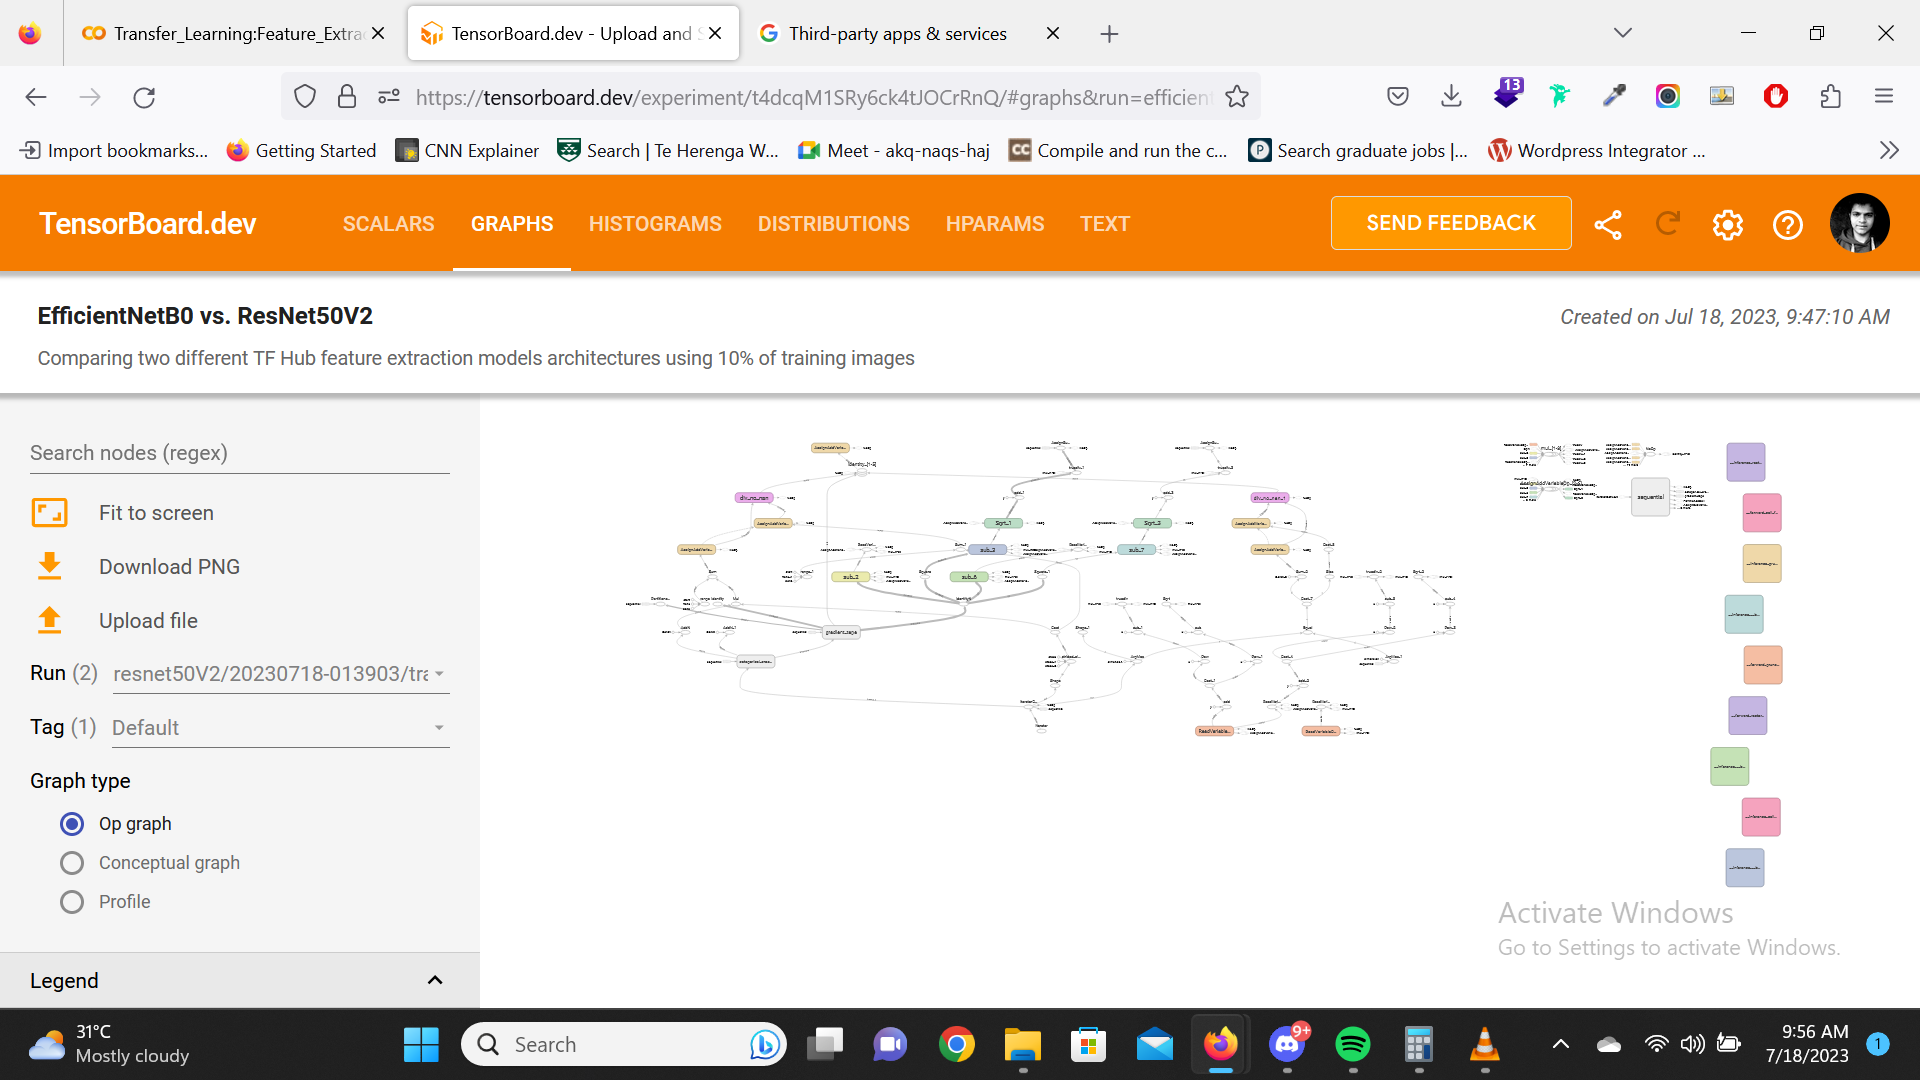